###### Import libraries

In [29]:
import os,sys,py3dep,xarray,rasterio,folium,geopandas,math,numpy,datetime,shutil,pynhd
import matplotlib.pyplot as plt
import whitebox_workflows as wbw
from pygeohydro import WBD
from shapely.geometry import Point

In [2]:
import hf_hydrodata as hf
hf.register_api_pin("evenson.grey@epa.gov", "2234")

###### Set run specific variables

In [3]:
ProjectDirectory = './BUCKHORN_CREEK'
DEMfname = r'C:\Users\GEVENSON\GitHub\BUCKHORN_CREEK\Data\DEM\BUCKHORN_CREEK_2M_DEM.tiff'
start_date = "2002-10-01"
end_date = "2006-10-01"
lat = 37.44870490000000 # lat, lon info: https://www.waterqualitydata.us/provider/NWIS/USGS-KY/USGS-03278100/
lon = -83.1954512000000

###### Set datetime dimension

In [4]:
start_date_split = start_date.split('-')
start_datetime_obj = datetime.datetime(year=int(start_date_split[0]),month=int(start_date_split[1]),day=int(start_date_split[2]))
end_date_split = end_date.split('-')
end_datetime_obj = datetime.datetime(year=int(end_date_split[0]),month=int(end_date_split[1]),day=int(end_date_split[2]))
dt_obj = datetime.timedelta(days=1)
datetime_dim = list()
i_time_obj = start_datetime_obj
while i_time_obj < end_datetime_obj:
    datetime_dim.append(i_time_obj)
    i_time_obj += dt_obj
datetime_dim = numpy.array(datetime_dim)

###### Hard code Parflow CONUS1 grid info (see https://hf-hydrodata.readthedocs.io/en/latest/available_grids.html)

In [5]:
conus1_proj = '+proj=lcc +lat_1=33 +lat_2=45 +lon_0=-96.0 +lat_0=39 +a=6378137.0 +b=6356752.31'
conus1_spatext = tuple([-121.47939483437318, 31.651836025255015, -76.09875469594509, 50.49802132270979])
conus1_transform = rasterio.transform.Affine(1000.0,0.0,-1885055.4995,0.0,1000.0,-604957.0654)

###### Create directory architecture

In [6]:
if not os.path.isdir(ProjectDirectory): os.mkdir(ProjectDirectory)
ProjectDataDirectory = os.path.join(ProjectDirectory,'Data')
if not os.path.isdir(ProjectDataDirectory): os.mkdir(ProjectDataDirectory)
ProjectWTDDataDirectory = os.path.join(ProjectDataDirectory,'WTD')
if not os.path.isdir(ProjectWTDDataDirectory): os.mkdir(ProjectWTDDataDirectory)
ProjectDEMDataDirectory = os.path.join(ProjectDataDirectory,'DEM')
if not os.path.isdir(ProjectDEMDataDirectory): os.mkdir(ProjectDEMDataDirectory)
ProjectTWIDataDirectory = os.path.join(ProjectDataDirectory,'TWI')
if not os.path.isdir(ProjectTWIDataDirectory): os.mkdir(ProjectTWIDataDirectory)
ProjectOutputDirectory = os.path.join(ProjectDirectory,'Output')
if not os.path.isdir(ProjectOutputDirectory): os.mkdir(ProjectOutputDirectory)

###### Identify HUC/domain

In [7]:
huc_level = 'huc12' 
idp = Point(lon, lat)
wbdbasins = WBD(huc_level) 
wbdbasins  = wbdbasins.bygeom(idp)
fname_domain = os.path.join(ProjectDataDirectory,'domain.gpkg')
domain = wbdbasins.dissolve()
domain.to_file(fname_domain, driver="GPKG")
del wbdbasins
del idp

###### Get domain lat/lon bounding box

In [8]:
lat_min = float(domain['geometry'].bounds['miny'].iloc[0])
lat_max = float(domain['geometry'].bounds['maxy'].iloc[0])
lon_min = float(domain['geometry'].bounds['minx'].iloc[0])
lon_max = float(domain['geometry'].bounds['maxx'].iloc[0])

###### Get domain bounding box for Parflow grid

In [9]:
grid_minx, grid_miny = hf.from_latlon("conus1", lat_min, lon_min)
grid_maxx, grid_maxy = hf.from_latlon("conus1", lat_max, lon_max)
grid_minx = math.floor(grid_minx)
grid_maxx = math.ceil(grid_maxx)
grid_miny = math.floor(grid_miny)
grid_maxy = math.ceil(grid_maxy)

###### Reset lat/lon bounding box to include border Parflow grid cells

In [10]:
latlon_bounds = hf.to_latlon("conus1", *[grid_minx, grid_miny, grid_maxx, grid_maxy])
lon_min = latlon_bounds[1]
lat_min = latlon_bounds[0]
lon_max = latlon_bounds[3]
lat_max = latlon_bounds[2]

In [30]:
domain.geometry[0].bounds

(-83.21603324796871, 37.39978480435785, -83.03942448377207, 37.5049420792161)

<Axes: >

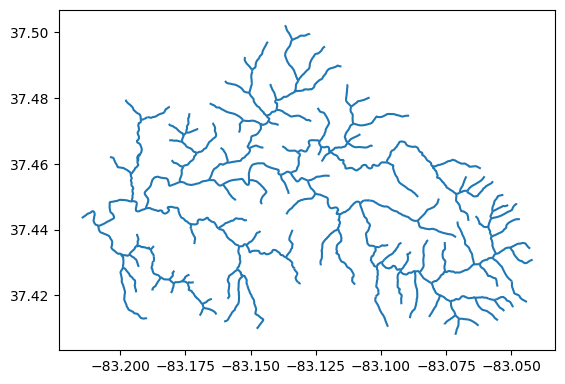

In [44]:
hr = pynhd.NHDPlusHR("flowline")
nhdp_hr = hr.bygeom(domain.geometry[0])
nhdp_hr.plot()

In [35]:
#from pynhd import NLDI, WaterData, NHDPlusHR

hr = pynhd.NHDPlusHR("flowline")
nhdp_hr = hr.bygeom(domain.geometry[0])

#dtavailability = py3dep.check_3dep_availability([lon_min,lat_min,lon_max,lat_max]) # can see availability here
#    dem_original = py3dep.get_dem(geometry=[lon_min,lat_min,lon_max,lat_max],resolution=10) # wpn't work with < 10 m
#    dem_original.rio.to_raster(fname_dem_original)

<Axes: >

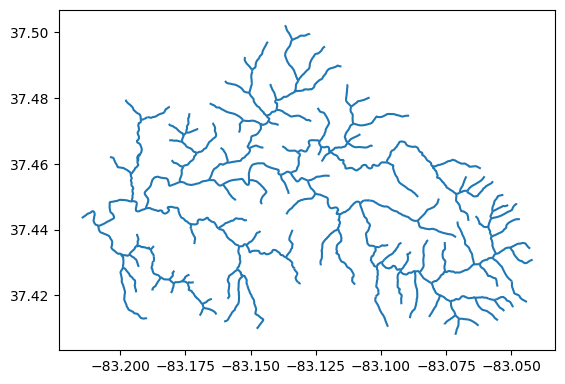

In [39]:
nhdp_hr.plot()

In [11]:
download_flag = False
fnames_wtd = list()
for datetime in datetime_dim:
    fname_wtd = os.path.join(ProjectWTDDataDirectory,'wtd_'+datetime.strftime('%Y%m%d')+'.tiff')
    if os.path.isfile(fname_wtd):
        fnames_wtd.append(fname_wtd)
    else:
        download_flag = True
        fnames_wtd = list() 
        break
if download_flag:
    options_wtd = {"dataset": "conus1_baseline_mod", "variable": "water_table_depth", "temporal_resolution": "daily", "start_time": start_date, "end_time": end_date, "grid_bounds":[grid_minx,grid_miny,grid_maxx,grid_maxy]}  
    hf_data = hf.get_gridded_data(options_wtd)
    if hf_data.shape[0] != int((end_datetime_obj - start_datetime_obj).days): print('ERROR hydrodata returned data of unexpected length.')
    hf_conus1grid_temp = numpy.empty((1888,3342))
    for i in range(len(datetime_dim)):
        idatetime = datetime_dim[i]
        hf_conus1grid_temp[grid_miny:grid_maxy,grid_minx:grid_maxx] = hf_data[i,:,:]
        memfile = rasterio.io.MemoryFile()
        hf_conus1data = memfile.open(driver = "GTiff", height = hf_conus1grid_temp.shape[0], width = hf_conus1grid_temp.shape[1], crs=conus1_proj, transform = conus1_transform, nodata = numpy.nan, count = 1, dtype = numpy.float64)
        hf_conus1data.write(hf_conus1grid_temp,1)
        fname = os.path.join(ProjectWTDDataDirectory,'wtd_'+idatetime.strftime('%Y%m%d')+'.tiff')
        wtd_data, wtd_transform = rasterio.mask.mask(hf_conus1data, domain['geometry'].to_crs(hf_conus1data.crs), crop=True, all_touched=True, filled =True, nodata = numpy.nan)
        wtd_meta = hf_conus1data.meta
        wtd_meta.update({"driver": "GTiff","height": wtd_data.shape[1],"width": wtd_data.shape[2],"transform": wtd_transform, "nodata" : numpy.nan})
        with rasterio.open(fname,'w',**wtd_meta) as wtd:
            wtd.write(wtd_data)

###### Download the Parflow water table depth data (if not already downloaded)

###### Increase resolution of ParFlow grid to 10 m (from 1000 m)
###### It seems like you could just do this on the fly, in-memory, per time step, after putting the topographic info into this grid using one instance of the wtd grid

In [12]:
fnames_wtd = [os.path.join(ProjectWTDDataDirectory,fname) for fname in os.listdir(ProjectWTDDataDirectory) if fname.find('highres') == -1 and fname.find('aux') ==-1]
fnames_wtd_highres = list()
for fname_wtd in fnames_wtd:
    fname_wtd_highres = fname_wtd.replace('.tiff','highres.tiff')
    if not os.path.isfile(fname_wtd_highres):
        with rasterio.open(fname_wtd) as wtd_dataset:
            wtd_data = wtd_dataset.read(out_shape=(wtd_dataset.count,int(wtd_dataset.height * 500),int(wtd_dataset.width * 500)),resampling=rasterio.enums.Resampling.cubic_spline)#nearest)
            wtd_transform = wtd_dataset.transform * wtd_dataset.transform.scale((wtd_dataset.width / wtd_data.shape[-1]),(wtd_dataset.height / wtd_data.shape[-2]))
            wtd_meta = wtd_dataset.meta
            wtd_meta.update({"driver": "GTiff","height": wtd_data.shape[1],"width": wtd_data.shape[2],"transform": wtd_transform, "nodata" : numpy.nan})
            with rasterio.open(fname_wtd_highres, "w", **wtd_meta) as wtd_highres:
                wtd_highres.write(wtd_data)
    fnames_wtd_highres.append(fname_wtd_highres)

###### Create domain mask

In [13]:
fname_domain_mask = os.path.join(ProjectDataDirectory,"domain_mask.tiff")
wtd_highres = rasterio.open(fnames_wtd_highres[0],'r')
domain_data = wtd_highres.read(1)
domain_meta = wtd_highres.meta
domain_crs = wtd_highres.crs
domain_transform = wtd_highres.transform
domain_mask = rasterio.features.rasterize(shapes=domain.to_crs(domain_crs)['geometry'],out_shape=domain_data.shape,transform=domain_transform,fill=0,all_touched=True,dtype=rasterio.uint8,default_value=1)
domain_meta.update({"driver": "GTiff","height": domain_data.shape[0],"width": domain_data.shape[1],"transform": domain_transform,"dtype": rasterio.uint8,"nodata":0})
with rasterio.open(fname_domain_mask, 'w', **domain_meta) as dst:
    dst.write(domain_mask,indexes=1)
del wtd_highres

###### Get DEM
###### NOTE: py3dep.check_3dep_availability may show availability of 1 meter resolution DEM but py3dep.get_dem does not work if called with resolution < 10, in my experience

In [14]:
fname_dem_original = os.path.join(ProjectDEMDataDirectory,"dem_original.tif")
if os.path.isfile(DEMfname):
    tmp = os.path.split(os.path.realpath(DEMfname))
    if tmp[1] != 'dem_original.tif' and tmp[0] != ProjectDEMDataDirectory:
        shutil.copy2(DEMfname,fname_dem_original)
else:
    print("FAIL")
    dtavailability = py3dep.check_3dep_availability([lon_min,lat_min,lon_max,lat_max]) # can see availability here
    dem_original = py3dep.get_dem(geometry=[lon_min,lat_min,lon_max,lat_max],resolution=10) # wpn't work with < 10 m
    dem_original.rio.to_raster(fname_dem_original)
dem_original = rasterio.open(fname_dem_original,'r')
dem_original_data = dem_original.read(1)
dem_original_crs = dem_original.crs
dem_original_transform = dem_original.transform
del dem_original #close dataset

###### Get ParFlow grid info

In [15]:
parflow_wtd_time0           = rasterio.open(fnames_wtd_highres[0],'r')
parflow_wtd_time0_data      = parflow_wtd_time0.read(1)
parflow_wtd_time0_crs       = parflow_wtd_time0.crs
parflow_wtd_time0_transform = parflow_wtd_time0.transform
parflow_wtd_time0_meta      = parflow_wtd_time0.meta
del parflow_wtd_time0 #close dataset

###### Reproject DEM to match resampled (high resolution) Parflow grid

In [16]:
dem_reprojected_data, dem_reprojected_transform = rasterio.warp.reproject(
        source = dem_original_data,
        destination = parflow_wtd_time0_data,
        src_transform=dem_original_transform,
        src_crs=dem_original_crs,
        dst_transform=parflow_wtd_time0_transform,
        dst_crs=parflow_wtd_time0_crs,
        resampling=rasterio.enums.Resampling.nearest)
dem_reprojected_data = dem_reprojected_data[0,:,:]
dem_reprojected_data = numpy.where(domain_mask==1,dem_reprojected_data,numpy.nan)
fname_dem = os.path.join(ProjectDEMDataDirectory,"dem_reprojected.tif")
parflow_wtd_time0_meta.update({"driver": "GTiff","height": dem_reprojected_data.shape[0],"width": dem_reprojected_data.shape[1],"transform": dem_reprojected_transform, "nodata":numpy.nan})
with rasterio.open(fname_dem, "w", **parflow_wtd_time0_meta) as dem_reprojected:
    dem_reprojected.write(dem_reprojected_data,1)

###### Initialize whitebox environment

In [17]:
wbe = wbw.WbEnvironment()

###### Breach the DEM (minimally invasive alternative to filling the DEM?)
###### https://www.whiteboxgeo.com/manual/wbt_book/available_tools/hydrological_analysis.html#BreachDepressionsLeastCost

In [18]:
fname_dem_breached = os.path.join(ProjectDEMDataDirectory,"dem_reprojected_breached.tif")
if not os.path.isfile(fname_dem_breached):
    dem_wbe = wbe.read_raster(fname_dem)
    dem_breached_wbe = wbe.breach_depressions_least_cost(dem=dem_wbe)
    wbe.write_raster(dem_breached_wbe, fname_dem_breached, compress=False)
    del dem_wbe, dem_breached_wbe

###### Calculate flow accumulation / watershed area (required for TWI calculation)

In [19]:
fname_acc = os.path.join(ProjectDEMDataDirectory,"flow_acc.tif")
if not os.path.isfile(fname_acc):
    dem_breached_wbe = wbe.read_raster(fname_dem_breached)
    acc_wbe = wbe.dinf_flow_accum(dem=dem_breached_wbe,out_type='sca',log_transform=False)                                         
    wbe.write_raster(acc_wbe, fname_acc, compress=False)
    del dem_breached_wbe, acc_wbe

###### Calculate slope (required for TWI calculation)

In [20]:
fname_slope = os.path.join(ProjectDEMDataDirectory,"slope.tif")
if not os.path.isfile(fname_slope):
    dem_wbe = wbe.read_raster(fname_dem_breached)
    slp_wbe = wbe.slope(dem=dem_wbe)   
    wbe.write_raster(slp_wbe, fname_slope, compress=False)
    del dem_wbe, slp_wbe

###### Calculate TWI

In [21]:
fname_twi = os.path.join(ProjectTWIDataDirectory,"twi.tif")
if not os.path.isfile(fname_twi):
    acc_wbe = wbe.read_raster(fname_acc)
    slp_wbe = wbe.read_raster(fname_slope)
    twi_wbe = wbe.wetness_index(specific_catchment_area=acc_wbe,slope=slp_wbe)
    wbe.write_raster(twi_wbe, fname_twi, compress=False)
    del acc_wbe, slp_wbe, twi_wbe

###### Upsample TWI to caculate mean TWI per Parflow grid cell 

In [22]:
fname_twi_upsample = os.path.join(ProjectTWIDataDirectory,"twi_upsample.tif")
if not os.path.isfile(fname_twi_upsample):
    with rasterio.open(fname_twi,'r') as twi_dataset:
        twi_upsample_data = twi_dataset.read(out_shape=(twi_dataset.count,int(twi_dataset.height / 100),int(twi_dataset.width / 100)),resampling=rasterio.enums.Resampling.average)
        twi_upsample_transform = twi_dataset.transform * twi_dataset.transform.scale((twi_dataset.width / twi_upsample_data.shape[-1]),(twi_dataset.height / twi_upsample_data.shape[-2]))
        twi_upsample_meta = twi_dataset.meta
        twi_upsample_meta.update({"driver": "GTiff","height": twi_upsample_data.shape[1],"width": twi_upsample_data.shape[2],"transform": twi_upsample_transform})
        with rasterio.open(fname_twi_upsample, "w", **twi_upsample_meta) as twi_upsample_dataset:
            twi_upsample_dataset.write(twi_upsample_data)

###### Downsample average Parflow grid cell TWI to high resolution ParFlow grid (to enable vectorized calculations of inundated area)

In [23]:
fname_twi_downsample = os.path.join(ProjectTWIDataDirectory,"twi_downsample.tif")
if not os.path.isfile(fname_twi_downsample):
    with rasterio.open(fname_twi_upsample,'r') as twi_upsample_dataset:
        twi_downsample_data = twi_upsample_dataset.read(out_shape=(twi_upsample_dataset.count,int(twi_upsample_dataset.height * 100),int(twi_upsample_dataset.width * 100)),resampling=rasterio.enums.Resampling.nearest)
        twi_downsample_transform = twi_upsample_dataset.transform * twi_upsample_dataset.transform.scale((twi_upsample_dataset.width / twi_downsample_data.shape[-1]),(twi_upsample_dataset.height / twi_downsample_data.shape[-2]))
        twi_downsample_meta = twi_upsample_dataset.meta
        twi_downsample_meta.update({"driver": "GTiff","height": twi_downsample_data.shape[1],"width": twi_downsample_data.shape[2],"transform": twi_downsample_transform})
        with rasterio.open(fname_twi_downsample, "w", **twi_downsample_meta) as twi_downsample_dataset:
            twi_downsample_dataset.write(twi_downsample_data)

###### Create the domain mask

###### Do the inundated area calculations

In [24]:
twi_local = rasterio.open(fname_twi,'r').read(1)
twi_mean = rasterio.open(fname_twi_downsample,'r').read(1)
domain_mask = rasterio.open(fname_domain_mask,'r').read(1)
for datetime in datetime_dim:
    fname_output = os.path.join(ProjectOutputDirectory,'inundatedarea_'+datetime.strftime('%Y%m%d')+'.tiff')
    #if not os.path.isfile(fname_output):
    fname_wtd_mean = os.path.join(ProjectWTDDataDirectory,'wtd_'+datetime.strftime('%Y%m%d')+'highres.tiff')
    wtd_mean = rasterio.open(fname_wtd_mean,'r').read(1)
    wtd_local = numpy.where(domain_mask==1,(1/2.6)*(twi_local-twi_mean) - wtd_mean,numpy.nan)
    wtd_local = numpy.where(wtd_local>=0,1,numpy.nan)
    with rasterio.open(fname_output, "w", **parflow_wtd_time0_meta) as wtd_local_dataset:
        wtd_local_dataset.write(wtd_local,1)

###### Create summary raster

In [28]:
fname_summary = os.path.join(ProjectOutputDirectory,'summary_grid_'+datetime_dim[0].strftime('%Y%m%d')+'_to_'+datetime_dim[len(datetime_dim)-1].strftime('%Y%m%d')+'.tiff')
count_grid = -1
for datetime in datetime_dim:
    if isinstance(count_grid,int): count_grid = numpy.zeros(output_data.shape) # init count_grid if start date
    fname_output = os.path.join(ProjectOutputDirectory,'inundatedarea_'+datetime.strftime('%Y%m%d')+'.tiff')
    output_data = rasterio.open(fname_output,'r').read(1)
    count_grid += numpy.where(output_data==1,1,0)
count_grid = numpy.where(count_grid==0,numpy.nan,count_grid) # convert to percent time that each cell is inundated
with rasterio.open(fname_summary, "w", **parflow_wtd_time0_meta) as summary_dataset:
    summary_dataset.write(count_grid,1)

###### Create folium map to QA spatial data

In [25]:
# MapIt -> True to turn on the map
MapIt = False
if MapIt:
    
    #Get raster values
    dem_val   = rasterio.open(fname_dem,'r').read(1)
    dem_b_val = rasterio.open(fname_dem_breached,'r').read(1)
    acc_val   = rasterio.open(fname_acc,'r').read(1)
    slp_val   = rasterio.open(fname_slope,'r').read(1)
    twi_val   = rasterio.open(fname_twi,'r').read(1)
    
    #Create colormaps
    dem_cm   = folium.LinearColormap(colors=['black','white'],vmin=dem_val.min(),   vmax=dem_val.max())
    dem_b_cm = folium.LinearColormap(colors=['black','white'],vmin=dem_b_val.min(), vmax=dem_b_val.max())
    acc_cm   = folium.LinearColormap(colors=['white','blue'], vmin=acc_val.min(),   vmax=acc_val.max())
    slp_cm   = folium.LinearColormap(colors=['white','red'],  vmin=slp_val.min(),   vmax=slp_val.max())
    twi_cm   = folium.LinearColormap(colors=['green','blue'], vmin=twi_val.min(),   vmax=twi_val.max())
    
    #Label the colormaps
    dem_cm.caption   = "Elevation"
    dem_b_cm.caption = "Elevation (Breached)"
    acc_cm.caption   = "Flow Accumulation"
    slp_cm.caption   = "Slope"
    twi_cm.caption   = "TWI"
    
    #Initialize folium map
    domain_centroid = domain.to_crs('+proj=cea').centroid.to_crs(domain.crs)
    domain_map = folium.Map([domain_centroid.y.iloc[0],domain_centroid.x.iloc[0]])
    
    #Add HUC boundaries to map
    fghuc = folium.FeatureGroup(name='HUC Boundary')
    for _, r in wbdbasins.iterrows():
        sim_geo = geopandas.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j)
        geo_j.add_to(fghuc)
    fghuc.add_to(domain_map)
    
    #Add images to folium map (TODO: Check assumption that image bounds match domain bounds. Also check interative, cross_origin arguments
    folium.raster_layers.ImageOverlay(name="DEM",image=dem_val,bounds=[[lat_min, lon_min], [lat_max, lon_max]],opacity=1,interactive=True,cross_origin=False,colormap = dem_cm, zindex=1).add_to(domain_map)
    folium.raster_layers.ImageOverlay(name="DEM (Breached)",image=dem_b_val,bounds=[[lat_min, lon_min], [lat_max, lon_max]],opacity=1,interactive=True,cross_origin=False,colormap = dem_b_cm, zindex=1).add_to(domain_map)
    folium.raster_layers.ImageOverlay(name="Flow Accumulation",image=acc_val,bounds=[[lat_min, lon_min], [lat_max, lon_max]],opacity=1,interactive=True,cross_origin=False,colormap = acc_cm, zindex=1).add_to(domain_map)
    folium.raster_layers.ImageOverlay(name="Slope",image=slp_val,bounds=[[lat_min, lon_min], [lat_max, lon_max]],opacity=1,interactive=True,cross_origin=False,colormap = acc_cm, zindex=1).add_to(domain_map)
    folium.raster_layers.ImageOverlay(name="TWI",image=twi_val,bounds=[[lat_min, lon_min], [lat_max, lon_max]],opacity=1,interactive=True,cross_origin=False,colormap = twi_cm, zindex=1).add_to(domain_map)
    
    #Add color bars to map
    dem_cm.add_to(domain_map)
    dem_b_cm.add_to(domain_map)
    acc_cm.add_to(domain_map)
    slp_cm.add_to(domain_map)
    twi_cm.add_to(domain_map)
    
    #Add layer control
    folium.LayerControl().add_to(domain_map)
    
    #Display map
    domain_map